In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import truncnorm
import math
import pandas as pd
import scipy.stats as sc
import random

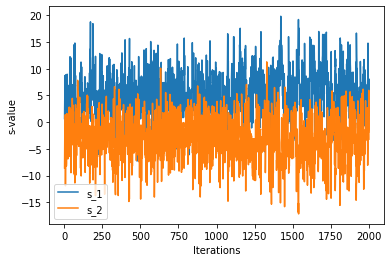

Time taken = 1.1168947219848633


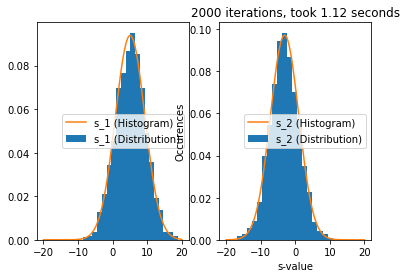

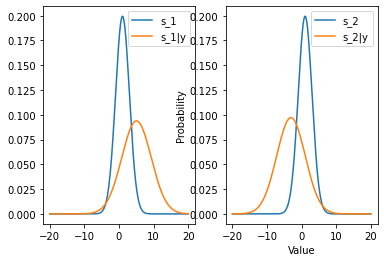

In [3]:
# Q5

def s_to_t(s1, s2, std_t): #Function to get t|s1,s2,y with s1, s2 as given values
    return truncnorm.rvs(0 - (s1-s2)/std_t, (np.inf - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, mu_s_vector, std_s_matrix, A): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

def normal_dist(mu, sig, t):
    return (1/np.sqrt(2*np.pi*sig))*np.exp(-((t-mu)**2)/(2*sig))


#Timer
time_taken = time.time()

#Starting µ and σ for S
mu_s = 1
std_s = 4
x_distri = np.linspace(-20,20,10000)
s1_dist = normal_dist(mu_s, std_s, x_distri)
s2_dist = normal_dist(mu_s, std_s, x_distri)
#The start is a ROW since it is an input to a function that generates 2d normal distributions
# The vector is a COLUMN since it is used in calculations as was done in Q3
mu_s_start = np.array([mu_s, mu_s])
mu_s_vector = np.array([[mu_s], [mu_s]])
std_s_matrix = np.array([[std_s**2, 0], [0, std_s**2]])
std_s_start = np.array([[std_s**2, 0], [0, std_s**2]])
A = np.array([[1, -1]]) # A-vector in the calculations
std_t = 5 # σ for t

Iters = 2000 #iterations
ab = 3 # burnout period
All_S = np.zeros((Iters, 2)) #Containing drawn S values
All_t = np.zeros(Iters) #Containing drawn t values

# Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
All_S[0] = [np.random.normal(loc=mu_s, scale = std_s), np.random.normal(loc=mu_s, scale = std_s)]

# We calculate t, then s, and repeat for as many times as the iterations
for i in range(Iters-1):
    All_t[i] = s_to_t(All_S[i,0], All_S[i,1], std_t)
    All_S[i+1] = t_to_s(All_t[i], mu_s_vector, std_s_matrix, A)

# Result vectors, x stores iterations, y stores s1 and s2, w stores µ1 and µ2
x = [i for i in range(ab,Iters)]
y1 = [All_S[i][0] for i in range(ab,Iters)]
y2 = [All_S[i][1] for i in range(ab,Iters)]


# How s changes (after burnout period)
plt.plot(x,y1)
plt.plot(x,y2)
plt.legend(["s_1", "s_2"])
plt.xlabel("Iterations")
plt.ylabel("s-value")
plt.show()

#FINDING NEW MEAN AND CO VARIANCE FROM DRAWN S1 AND S2 FOR POSTERIOR DISTRIBUTION

#Finding mean
mu_S1 = np.mean(y1)
mu_S2 = np.mean(y2)

#Finding the Covariance matrix
co_11 = 0
co_121 = 0
co_22 = 0

for i in range(len(y1)):
    co_11 += (y1[i]-mu_S1)**2
    co_22 += (y2[i]-mu_S2)**2
    co_121 += (y1[i]-mu_S1)*(y2[i]-mu_S2)

co_11 /= len(y1)-1
co_121 /= len(y1)-1
co_22 /= len(y2)-1

# Putting the results into a vector (µ) and a matrix (covariance)
mu_vector = np.array([mu_S1, mu_S2])
covariance_matrix = np.array([[co_11, co_121], [co_121, co_22]])


s1_ny_dist = normal_dist(mu_S1, co_11, x_distri)
s2_ny_dist = normal_dist(mu_S2, co_22, x_distri)

# Samples excluding the burnout period
samples_drawn = Iters - ab

# Draws samples from the original µ values and covariance matrix, the draws values from the new M values and covariance matrix
All_samples_drawn = np.zeros((samples_drawn, 2))
Samples_from_start = np.zeros((samples_drawn, 2))
for i in range(samples_drawn):
    All_samples_drawn[i] = np.random.multivariate_normal(mu_vector, covariance_matrix)
    Samples_from_start[i] = np.random.multivariate_normal(mu_s_start, std_s_start)

#Results are split into new s1, s2 and starting value for s1, s2
newy1 = [All_samples_drawn[i][0] for i in range(samples_drawn)]
newy2 = [All_samples_drawn[i][1] for i in range(samples_drawn)]

#start1 = [Samples_from_start[i][0] for i in range(samples_drawn)]
#start2 = [Samples_from_start[i][1] for i in range(samples_drawn)]

#Timer stops, for accurate time comment out all the plots
time_taken = time.time() - time_taken
print(f"Time taken = {time_taken}")

#Shows the new distribution
figure, axis = plt.subplots(1,2)
axis[0].hist(newy1, density=1, bins=20)
axis[0].plot(x_distri, s1_ny_dist)
axis[0].legend(["s_1 (Histogram)", "s_1 (Distribution)"])

axis[1].hist(newy2, density=1, bins=20)
axis[1].plot(x_distri, s2_ny_dist)
axis[1].legend(["s_2 (Histogram)", "s_2 (Distribution)"])

plt.xlabel("s-value")
plt.ylabel("Occurences")
plt.title(f"{Iters} iterations, took {round(time_taken, 2)} seconds")

plt.show()

#shows the start distribution (s1, s2) and the resulting distribution (s1, s2|y)
figure, axis = plt.subplots(1,2)
axis[0].plot(x_distri, s1_dist)
axis[0].plot(x_distri, s1_ny_dist)
axis[0].legend(['s_1', 's_1|y'])

axis[1].plot(x_distri, s2_dist)
axis[1].plot(x_distri, s2_ny_dist)
axis[1].legend(['s_2', 's_2|y'])

plt.xlabel("Value")
plt.ylabel("Probability")
plt.show()

In [4]:
# Q6
#Class for every team, showing µ, σ and team name
class team:
    def __init__(self, mu, var, name, skill):
        self.mu = mu
        self.var = var
        self.name = name
        self.skill = skill

def s_to_t(s1, s2, std_t, score): #Function to get t|s1,s2,y with s1, s2 as given values
    if score == -1:
        minval, maxval = -np.inf, 0
    else:
        minval, maxval = 0, np.inf
    return truncnorm.rvs(minval - (s1-s2)/std_t, (maxval - (s1-s2)/std_t), loc = (s1-s2), scale = std_t)

def t_to_s(t, A, std_t, std_s_matrix, mu_s_vector): #Function to get s1,s2|t,y with t as a given value
    std_s_matrix_old = std_s_matrix
    std_s_matrix = np.linalg.inv(np.linalg.inv(std_s_matrix_old) + (A.reshape(-1, 1) * (1/std_t)) @ A)
    mu_s_vector = std_s_matrix@(np.linalg.inv(std_s_matrix_old) @ mu_s_vector + A.reshape(-1, 1) * (1/std_t)*t)
    mu_s_transpose = mu_s_vector.reshape(1, -1)[0]
    return np.random.multivariate_normal(mu_s_transpose, std_s_matrix)

std_t = 5 # starting σ for t

#Reads the data, the path has to be changed depending on where your target folder is in vs code, here the target folder is AML
input_data = pd.read_csv("SerieA.csv")

#Creates list of names
team_list = []
for teams in input_data["team1"]:
    if teams not in team_list:
        team_list.append(teams)

for teams in input_data["team2"]:
    if teams not in team_list:
        team_list.append(teams)

#Creates a list with all the teams (i.e. a list of classes)
team_data = []
for i in team_list:
    team_data.append(team(1,4,i,0))

Iters = 1000 #Iterations
ab = 20 #After burnout
A = np.array([[1, -1]]) # A-vector in the calculations

#Main loop
nr_matches = len(input_data["team1"])
for iteration in range(nr_matches):
    print(f"Calculating match {iteration} of {nr_matches}")
    i = iteration # Doing matches in sequence
    #i = nr_matches-1-iteration # doing matches in reverse
    #Get the score, if score is 0, the match is ignored
    score = input_data["score1"][i] - input_data["score2"][i]
    if score == 0:
        continue

    #Only the sign of the score is used
    score = np.sign(score)

    #Get the correct team data by fetching the names and then using the classes corresponding to those names
    team_1_name = input_data["team1"][i]
    team_2_name = input_data["team2"][i]

    for j in range(len(team_data)):
        if team_data[j].name == team_1_name:
            team1 = team_data[j]
        if team_data[j].name == team_2_name:
            team2 = team_data[j]
            

    #Set up µ-vector and covariance matrix
    mu_s_vector = np.array([[team1.mu], [team2.mu]])
    std_s_matrix = np.array([[team1.var**2, 0], [0, team2.var**2]])

    All_S = np.zeros((Iters, 2)) #Containing drawn S values
    All_t = np.zeros(Iters) #Containing drawn t values

    # Matrices where the s1 and s2 random values are stored as well as the µ-values (in All_Mu_S)
    All_S[0] = [np.random.normal(loc=team1.mu, scale = team1.var), np.random.normal(loc=team2.mu, scale = team2.var)]

    # We calculate t, then s, and repeat for as many times as the iterations
    for j in range(Iters-1):
        All_t[j] = s_to_t(All_S[j,0], All_S[j,1], std_t, score)
        All_S[j+1] = t_to_s(All_t[j], A, std_t, std_s_matrix, mu_s_vector)

    #Getting s1 and s2 values
    y1 = [All_S[j][0] for j in range(ab,Iters)]
    y2 = [All_S[j][1] for j in range(ab,Iters)]

    #Getting µ and σ
    mu_team1 = np.mean(y1)
    mu_team2 = np.mean(y2)
    var_team1 = 0
    var_team2 = 0
    for j in range(len(y1)):
        var_team1 += (y1[j]-mu_team1)**2
        var_team2 += (y2[j]-mu_team2)**2
    var_team1 /= len(y1)-1
    var_team2 /= len(y1)-1
    var_team1 = math.sqrt(var_team1)
    var_team2 = math.sqrt(var_team2)
    team1.mu = mu_team1
    team2.mu = mu_team2
    team1.var = var_team1
    team2.var = var_team2

#Drawing 100 random numbers from the distributions to determine skill
for current_team in team_data:
    for i in range(100):
        partial_skill = np.random.normal(loc=current_team.mu, scale = current_team.var)/100
        current_team.skill += partial_skill

team_data.sort(key=lambda team: team.skill, reverse=True)

print("TEAM SKILLS AND RANKINGS:")
for i in range(len(team_data)):
    print(f"{i+1}. {team_data[i].name}: {round(team_data[i].skill, 2)} mu={team_data[i].mu}, std={team_data[i].var}")

    

Calculating match 0 of 380
Calculating match 1 of 380
Calculating match 2 of 380
Calculating match 3 of 380
Calculating match 4 of 380
Calculating match 5 of 380
Calculating match 6 of 380
Calculating match 7 of 380
Calculating match 8 of 380
Calculating match 9 of 380
Calculating match 10 of 380
Calculating match 11 of 380
Calculating match 12 of 380
Calculating match 13 of 380
Calculating match 14 of 380
Calculating match 15 of 380
Calculating match 16 of 380
Calculating match 17 of 380
Calculating match 18 of 380
Calculating match 19 of 380
Calculating match 20 of 380
Calculating match 21 of 380
Calculating match 22 of 380
Calculating match 23 of 380
Calculating match 24 of 380
Calculating match 25 of 380
Calculating match 26 of 380
Calculating match 27 of 380
Calculating match 28 of 380
Calculating match 29 of 380
Calculating match 30 of 380
Calculating match 31 of 380
Calculating match 32 of 380
Calculating match 33 of 380
Calculating match 34 of 380
Calculating match 35 of 380
Ca

In [8]:
def prediction(mu1, mu2, std1, std2, y, N):
    #will try to predict N simulations of given match and return how many are correct
    t=np.zeros(N)
    mut=np.random.normal(mu1,std1,N)-np.random.normal(mu1,std1,N)
    for i in range(N):
        t[i]=np.random.normal(mut[i],5)
    accuracy=sum(y==np.sign(t))/N
    return accuracy


def prediction_rate(outcome, input_data, teams_data):

    #all usefull data from the result of
    team1 = input_data["team1"] #list of team ones
    team2 = input_data["team2"] #list of team twos

    #makes library of the team class.names and gives them a number for easier use
    teams = {}
    for j in range(len(team_data)): 
        teams[team_data[j].name]=j
    
    n_games = len(np.array(team1))  # number of games
    accuracy, total_games = 0, 0 

    # Loop over all games
    for game in range(n_games):
        print(f"{game} of {n_games}: {(game/n_games*100):.2f}%")

        y = outcome[game]
        if y != 0:  #no ties allowed
            # Get mean and variance of the teams
            home_team = team1[game]
            away_team = team2[game]
            std1 = teams_data[teams[home_team]].var
            std2 = teams_data[teams[home_team]].var
            mu1 = teams_data[teams[home_team]].mu
            mu2 = teams_data[teams[home_team]].mu
            
            # Calculate the amount of correct guesses of result
            total_games = total_games + 1
            accuracy += prediction(mu1, mu2, std1, std2, y) #use prediction function

    
    return accuracy/total_games # return r



def main():
    column_names = ['date', 'time', 'team1', 'team2', 'score1', 'score2']
    data = pd.read_csv("SerieA.csv", names=column_names, skiprows=1)

    team1 = np.array(data.team1.tolist())
    team2 = np.array(data.team2.tolist())

    result = np.sign(np.array(data.score1.tolist()) - np.array(data.score2.tolist()))
    nr_games = len(np.array(team1))

    unique_teams = np.unique(np.concatenate((team1, team2)))

    teams = {}
    for idx in range(len(unique_teams)):
        teams[unique_teams[idx]] = idx

    nr_of_teams = len(unique_teams)

    team_mean = np.zeros(nr_of_teams)
    team_var = np.ones(nr_of_teams)

    burn_in = 2
    N_samples = 100

    # Original order of games
    prediction_rate_original = rank_predictor_guess(teams, result, team1, team2, team_mean, team_var, burn_in, N_samples)


    # Shuffled order of games
    original_order = list(range(nr_games))
    random.shuffle(original_order)
    result = [result[i] for i in original_order]
    team1 = [team1[i] for i in original_order]
    team2 = [team2[i] for i in original_order]
    prediction_rate_shuffled = rank_predictor_guess(teams, result, team1, team2, team_mean, team_var, burn_in, N_samples)

    # Random guessing
    correct_guess, total_games = 0, 0
    for i in range(nr_games):
        if result[i] != 0:
            total_games += 1
            if (random.randint(0,1)*2)-1 == result[i]:
                correct_guess += 1
    prediction_rate_random = correct_guess/total_games

    print(f"Prediction Rate with orginal order of games: r={prediction_rate_original:.5f}")
    print(f"Prediction Rate with shuffled order of games: r={prediction_rate_shuffled:.5f}")
    print(f"Prediction Rate with random guessing of games: r={prediction_rate_random:.5f}")


main()

'Atalanta'